In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
file_path = r"C:\Users\franc\Desktop\ML_IoT\df_final_for_training.csv"
df_final_for_training = pd.read_csv(file_path)

In [15]:
df_final_for_training.columns

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
       'BsmtFinSF1', '2ndFlrSF', 'GarageCars', 'YearBuilt', 'GarageArea'],
      dtype='object')

### Solo ajustes hiperparámetros clave

In [4]:
# Separar variables predictoras (X) y la variable objetivo (y)
X = df_final_for_training.drop(columns=["SalePrice"])
y = df_final_for_training["SalePrice"]

# Dividir en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los nuevos hiperparámetros clave ajustados
optimized_params = {
    'n_estimators': 300, 
    'learning_rate': 0.05,  
}

# Entrenar XGBoost con los nuevos hiperparámetros clave
xgb_optimized = XGBRegressor(**optimized_params, random_state=42)
xgb_optimized.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred_optimized = xgb_optimized.predict(X_test)

# Evaluar el modelo con los nuevos hiperparámetros clave
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
r2_optimized = r2_score(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)

# Mostrar resultados comparativos
results_optimized = pd.DataFrame({
    "Modelo": ["XGBoost Optimizado (n_estimators & learning_rate)"],
    "RMSE": [rmse_optimized],
    "R2": [r2_optimized],
    "MAE": [mae_optimized]
})

results_optimized["Accuracy (%)"] = results_optimized["R2"] * 100
results_optimized

,Modelo,RMSE,R2,MAE,Accuracy (%)
0,XGBoost Optimizado (n_estimators & learning_rate),28524.277586,0.893924,19039.135314,89.392441


#### Resultado:
 
- Mejoramos el rendimiento del modelo hasta un 89.4%

#### Predecir sobre el conjunto de prueba

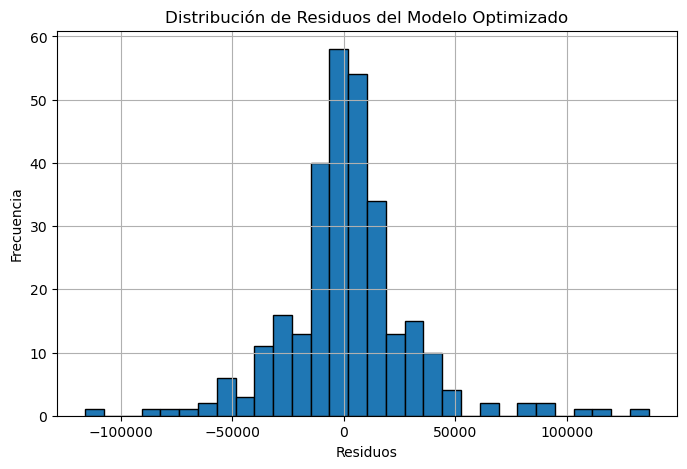

,Métrica,Valor
0,RMSE (Test),28524.277586
1,R² (Test),0.893924
2,MAE (Test),19039.135314
3,R2 Cross-Validation Promedio,0.817376


In [7]:

y_pred_optimized = xgb_optimized.predict(X_test)

# Validación con conjunto de prueba
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
test_r2 = r2_score(y_test, y_pred_optimized)
test_mae = mean_absolute_error(y_test, y_pred_optimized)

# Validación cruzada (5 folds)
cv_scores = cross_val_score(xgb_optimized, X_train, y_train, cv=5, scoring='r2')

# Análisis de residuos
residuals = y_test - y_pred_optimized

# Graficar distribución de residuos
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos del Modelo Optimizado")
plt.grid(True)
plt.show()

# Guardar resultados en un DataFrame
validation_results = pd.DataFrame({
    "Métrica": ["RMSE (Test)", "R² (Test)", "MAE (Test)", "R2 Cross-Validation Promedio"],
    "Valor": [test_rmse, test_r2, test_mae, np.mean(cv_scores)]
})

validation_results

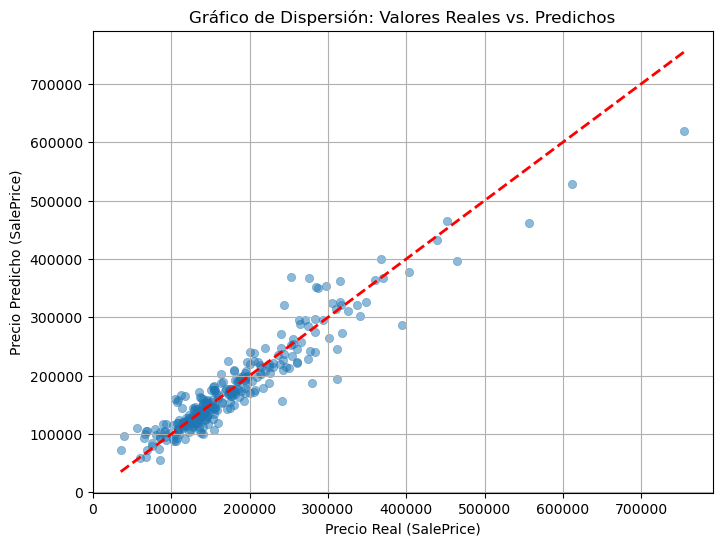

In [28]:
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_optimized, alpha=0.5, edgecolor=None)

# Línea ideal de ajuste
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2)

# Etiquetas y título
plt.xlabel("Precio Real (SalePrice)")
plt.ylabel("Precio Predicho (SalePrice)")
plt.title("Gráfico de Dispersión: Valores Reales vs. Predichos")
plt.grid(True)

# Mostrar el gráfico
plt.show()


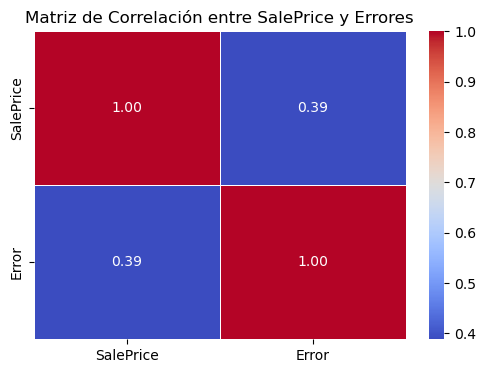

In [30]:
# Calcular los errores (residuos)
errores = y_test - y_pred_optimized

# Crear un DataFrame con SalePrice y los errores
df_errores = pd.DataFrame({"SalePrice": y_test, "Error": errores})

# Calcular la correlación entre SalePrice y los errores
correlation_matrix = df_errores.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre SalePrice y Errores")
plt.show()


### Guardar el modelo y la documentación

Se guardara en la misma carpeta donde se ejecuta el código 

In [19]:
import joblib
import json

# Guardar el modelo en un archivo .pkl
model_filename = "xgb_optimized_model.pkl"
joblib.dump(xgb_optimized, model_filename)

# Crear documentación del modelo
model_info = {
    "Descripción": "Modelo XGBoost optimizado para predicción de precios de viviendas",
    "Variables Utilizadas": list(X.columns),
    "Rendimiento (Test)": {
        "RMSE": 28524.277586,
        "R²": 0.893924,
        "MAE": 19039.135314
    },
    "Instrucciones": "Para usar este modelo, cargarlo con joblib.load('xgb_optimized_model.pkl') y usar .predict(X) sobre nuevos datos."
}

# Guardar la documentación en un archivo JSON
doc_filename = "xgb_model_info.json"
with open(doc_filename, "w") as f:
    json.dump(model_info, f, indent=4)

print(f"Modelo guardado como {model_filename}")
print(f"Documentación guardada como {doc_filename}")


Modelo guardado como xgb_optimized_model.pkl
Documentación guardada como xgb_model_info.json
